In [2]:
# %reset -f

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import missingno as msno
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
# libraries required for the animation plot
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [5]:
# read in our airquality dataset
columns_to_read = ["StationId", "Datetime", "PM2.5", "PM10", "NO", "NO2", "NOx", "NH3", "CO", "SO2", "O3", "Benzene", "Toluene", "Xylene", "AQI"]
df = pd.read_csv('data/ni_station_hourly.csv', usecols=columns_to_read)
df.head()

StationId             Datetime  PM2.5  PM10  NO  NO2  NOx  NH3  CO  SO2  O3  \
0     DL002  2017-10-01 00:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
1     DL002  2017-10-01 01:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
2     DL002  2017-10-01 02:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
3     DL002  2017-10-01 03:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
4     DL002  2017-10-01 04:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   

   Benzene  Toluene  Xylene  AQI  
0      NaN      NaN     NaN  NaN  
1      NaN      NaN     NaN  NaN  
2      NaN      NaN     NaN  NaN  
3      NaN      NaN     NaN  NaN  
4      NaN      NaN     NaN  NaN

In [6]:
## AQI Categories
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["AQI_Category"] = df["AQI"].apply(lambda x: get_AQI_bucket(x))
df.head()

StationId             Datetime  PM2.5  PM10  NO  NO2  NOx  NH3  CO  SO2  O3  \
0     DL002  2017-10-01 00:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
1     DL002  2017-10-01 01:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
2     DL002  2017-10-01 02:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
3     DL002  2017-10-01 03:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
4     DL002  2017-10-01 04:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   

   Benzene  Toluene  Xylene  AQI AQI_Category  
0      NaN      NaN     NaN  NaN          NaN  
1      NaN      NaN     NaN  NaN          NaN  
2      NaN      NaN     NaN  NaN          NaN  
3      NaN      NaN     NaN  NaN          NaN  
4      NaN      NaN     NaN  NaN          NaN

In [7]:
df.AQI_Category.value_counts()

AQI_Category
Moderate        139841
Very Poor       107268
Poor             69958
Satisfactory     68384
Severe           34127
Good              6724
Name: count, dtype: int64

In [8]:
# Load station latitude and longitude
ni_stations_lat_lon = pd.read_csv('data/ni_stations_lat_lon.csv')
ni_stations_lat_lon.head()

StationId        Lon        Lat
0     DL002  28.650179  77.302986
1     DL004  28.472728  77.132252
2     DL006  28.728763  77.197949
3     DL007  28.551865  77.275382
4     DL008  28.752428  77.129004

In [9]:
# Add latitude and longitude to the "df" dataframe
df = pd.merge(df, ni_stations_lat_lon, on='StationId', how='left')
df.head()

StationId             Datetime  PM2.5  PM10  NO  NO2  NOx  NH3  CO  SO2  O3  \
0     DL002  2017-10-01 00:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
1     DL002  2017-10-01 01:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
2     DL002  2017-10-01 02:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
3     DL002  2017-10-01 03:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   
4     DL002  2017-10-01 04:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN NaN   

   Benzene  Toluene  Xylene  AQI AQI_Category        Lon        Lat  
0      NaN      NaN     NaN  NaN          NaN  28.650179  77.302986  
1      NaN      NaN     NaN  NaN          NaN  28.650179  77.302986  
2      NaN      NaN     NaN  NaN          NaN  28.650179  77.302986  
3      NaN      NaN     NaN  NaN          NaN  28.650179  77.302986  
4      NaN      NaN     NaN  NaN          NaN  28.650179  77.302986

In [10]:
# Convert the 'Datetime' column to a pandas datetime object
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Sort DataFrame by 'Datetime'
# df = df.sort_values(by='Datetime') # THIS SORTING HAS SOME ISSUE WHICH REMOVES TIME COMPONENT FROM DATETIME FIELD. INVESTIGATE THIS LATER.

# Extract year from the 'Datetime' column
df['Year'] = df['Datetime'].dt.year

# Add a new column 'Month' with month names
df['Month'] = df['Datetime'].dt.strftime('%B')

# Add a new column 'DayOfWeek'
df['DayOfWeek'] = df['Datetime'].dt.day_name()

# Add a new column 'HourOfDay'
df['HourOfDay'] = df['Datetime'].dt.hour

df.head()

StationId            Datetime  PM2.5  PM10  NO  NO2  NOx  NH3  CO  SO2  ...  \
0     DL002 2017-10-01 00:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   
1     DL002 2017-10-01 01:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   
2     DL002 2017-10-01 02:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   
3     DL002 2017-10-01 03:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   
4     DL002 2017-10-01 04:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   

   Toluene  Xylene  AQI  AQI_Category        Lon        Lat  Year    Month  \
0      NaN     NaN  NaN           NaN  28.650179  77.302986  2017  October   
1      NaN     NaN  NaN           NaN  28.650179  77.302986  2017  October   
2      NaN     NaN  NaN           NaN  28.650179  77.302986  2017  October   
3      NaN     NaN  NaN           NaN  28.650179  77.302986  2017  October   
4      NaN     NaN  NaN           NaN  28.650179  77.302986  2017  October   

   DayOfWeek HourOfDay  
0     Sunday         0  
1     Sunday         1  
2     Sunday         2  
3     Sunday         3  
4     Sunday         4  

[5 rows x 22 columns]

### Feature Engineering

In [11]:
# Calculate volatilities for daily, weekly, and monthly rolling windows per station
df['Volatility_Last1D'] = df.groupby('StationId')['AQI'].rolling(window=24).std().reset_index(level=0, drop=True)
df['Volatility_Last7D'] = df.groupby('StationId')['AQI'].rolling(window=24 * 7).std().reset_index(level=0, drop=True)
df['Volatility_Last30D'] = df.groupby('StationId')['AQI'].rolling(window=24 * 30).std().reset_index(level=0, drop=True)

# Calculate moving average for weekly, and monthly rolling windows per station
df['MA_Last7D'] = df.groupby('StationId')['AQI'].rolling(window=24 * 7).mean().reset_index(level=0, drop=True)
df['MA_Last30D'] = df.groupby('StationId')['AQI'].rolling(window=24 * 30).mean().reset_index(level=0, drop=True)

df.head()

StationId            Datetime  PM2.5  PM10  NO  NO2  NOx  NH3  CO  SO2  ...  \
0     DL002 2017-10-01 00:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   
1     DL002 2017-10-01 01:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   
2     DL002 2017-10-01 02:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   
3     DL002 2017-10-01 03:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   
4     DL002 2017-10-01 04:00:00    NaN   NaN NaN  NaN  NaN  NaN NaN  NaN  ...   

         Lat  Year    Month  DayOfWeek  HourOfDay Volatility_Last1D  \
0  77.302986  2017  October     Sunday          0               NaN   
1  77.302986  2017  October     Sunday          1               NaN   
2  77.302986  2017  October     Sunday          2               NaN   
3  77.302986  2017  October     Sunday          3               NaN   
4  77.302986  2017  October     Sunday          4               NaN   

   Volatility_Last7D  Volatility_Last30D  MA_Last7D MA_Last30D  
0                NaN                 NaN        NaN        NaN  
1                NaN                 NaN        NaN        NaN  
2                NaN                 NaN        NaN        NaN  
3                NaN                 NaN        NaN        NaN  
4                NaN                 NaN        NaN        NaN  

[5 rows x 27 columns]

In [12]:
df.isna().sum()

StationId                  0
Datetime                   0
PM2.5                  77666
PM10                  172512
NO                     71151
NO2                    58307
NOx                    67731
NH3                   304548
CO                     76570
SO2                   233832
O3                     87389
Benzene               203326
Toluene               228465
Xylene                380887
AQI                    73182
AQI_Category           73182
Lon                        0
Lat                        0
Year                       0
Month                      0
DayOfWeek                  0
HourOfDay                  0
Volatility_Last1D      87753
Volatility_Last7D     156768
Volatility_Last30D    301307
MA_Last7D             156768
MA_Last30D            301307
dtype: int64

<Axes: >

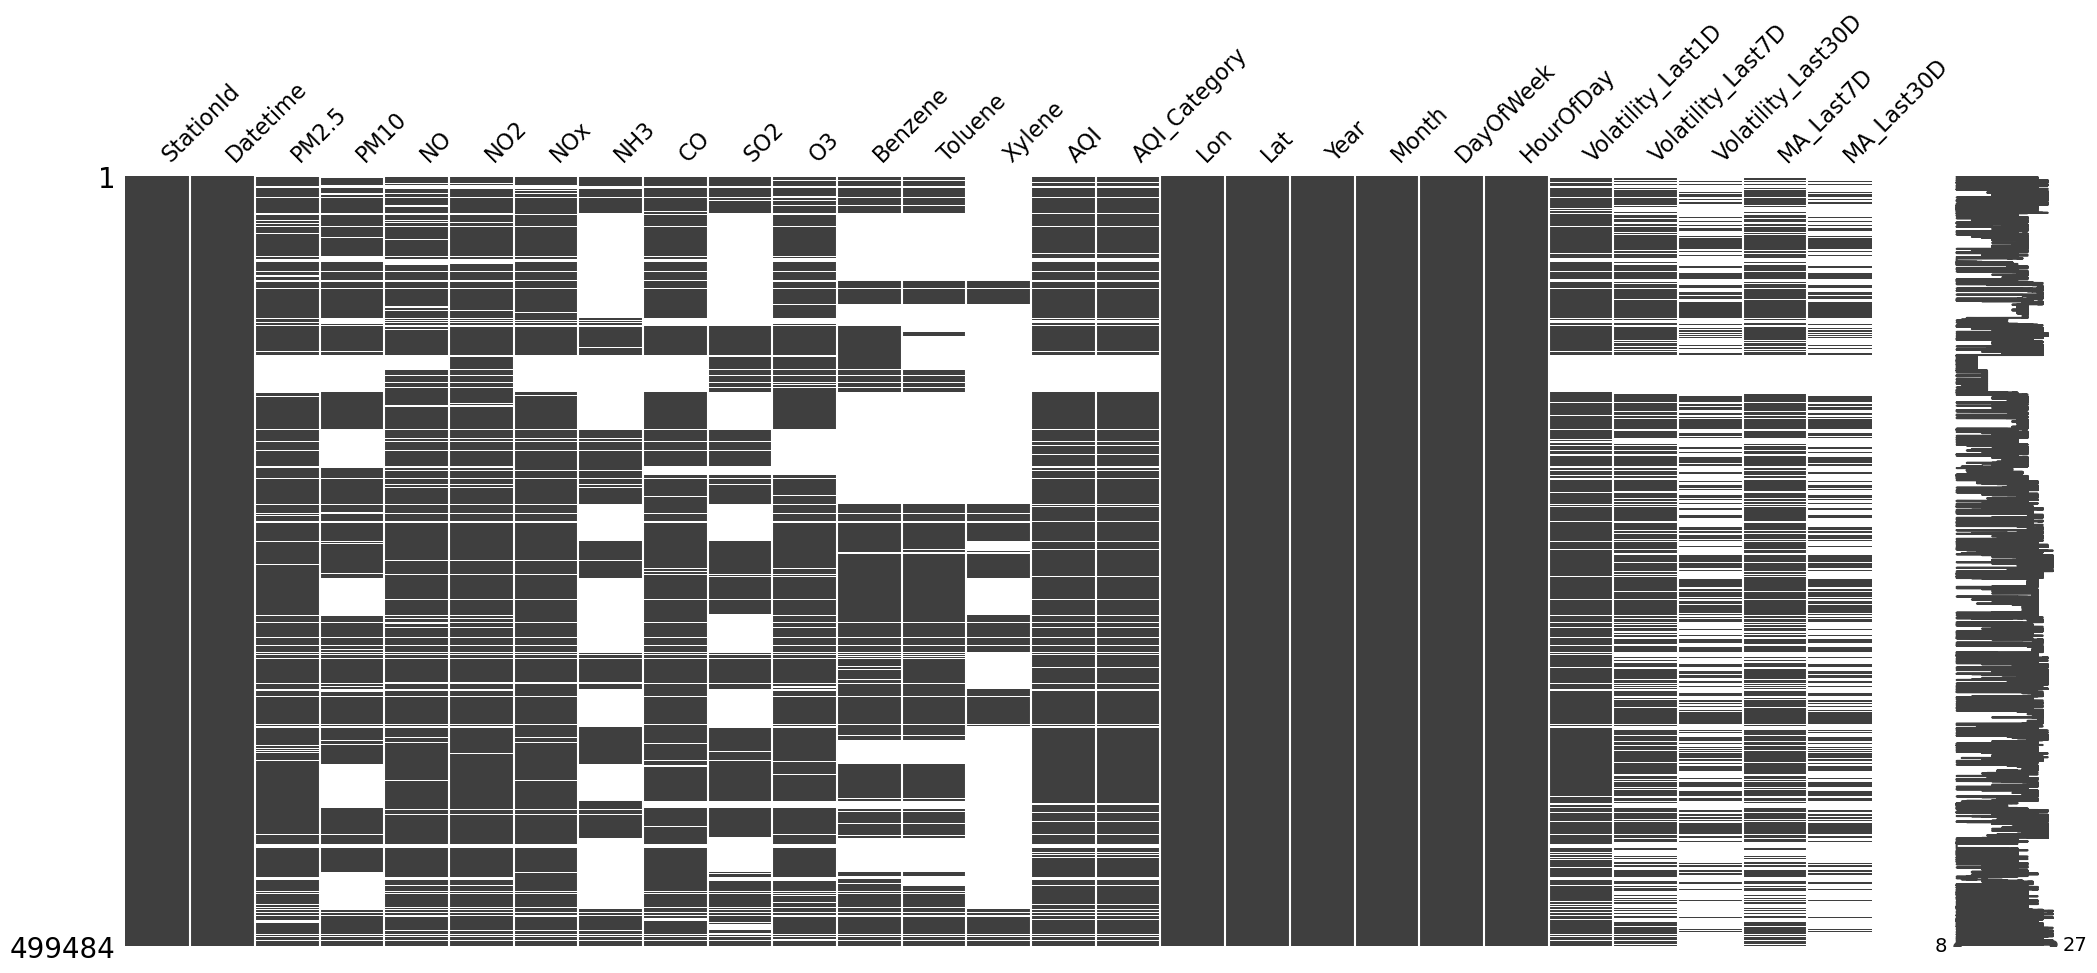

In [13]:
msno.matrix(df)

## Analyze missing AQI

In [14]:
total_records = df.groupby('StationId').size().reset_index(name='TotalRecords')
missing_aqi_records = df[df['AQI'].isna()].groupby('StationId').size().reset_index(name='MissingAQIRecords')

# Merge the two results on StationId
result = pd.merge(total_records, missing_aqi_records, on='StationId', how='left').fillna(0)
result = result.sort_values(by='MissingAQIRecords', ascending=False).reset_index(drop=True)

result.head(50)

StationId  TotalRecords  MissingAQIRecords
0      DL011         24097              24097
1      HR011         21912               4927
2      HR014         24097               4132
3      DL006         19729               4091
4      DL002         24097               3858
5      DL014         24097               3295
6      DL034         24097               3033
7      DL025         24097               2852
8      DL008         24097               2762
9      PB001         24097               2672
10     DL030         24097               2599
11     DL017         24097               2430
12     DL028         24097               1880
13     DL013         24097               1638
14     DL019         24097               1638
15     DL004         24097               1634
16     DL031         24097               1546
17     DL012         24097               1353
18     DL007         24097               1323
19     DL033         24097               1051
20     DL021         24097                371

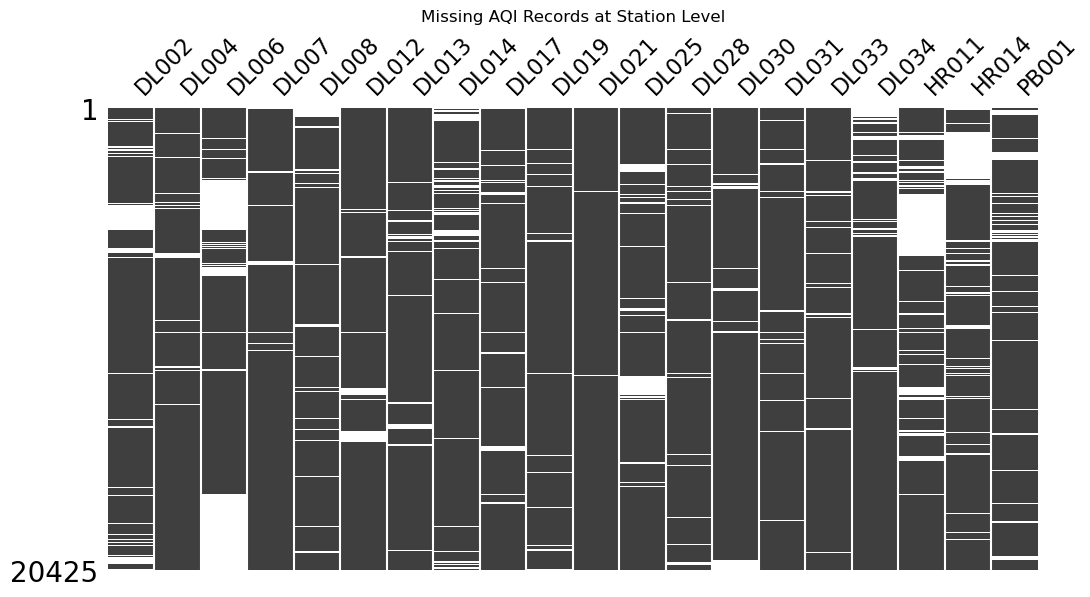

In [15]:
start_date = '2018-01-01'
end_date = '2020-05-01'
df_missing_aqi_at_station = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)]
df_missing_aqi_at_station = df_missing_aqi_at_station.sort_values(by=['StationId', 'Datetime'], ascending=False).reset_index(drop=True)

# Create a matrix of missing values
missing_aqi_matrix = df_missing_aqi_at_station.pivot_table(index='Datetime', columns='StationId', values='AQI', aggfunc='max')

# Plot the matrix using missingno
msno.matrix(missing_aqi_matrix, figsize=(12, 6), sparkline=False, labels=True)
plt.title('Missing AQI Records at Station Level')
plt.show()

In [16]:
# DON'T DELETE 'NA' - 'AQI' RECORDS UNTIL ALL FEATURES REQUIRING HOURLY ROLLING WINDOW EXTRACTION ARE PROCESSED
df = df.dropna(subset=['AQI']).reset_index(drop=True)
df.head()

StationId            Datetime  PM2.5   PM10     NO     NO2     NOx     NH3  \
0     DL002 2017-10-24 06:00:00  249.0  633.0    NaN  125.63     NaN  138.29   
1     DL002 2017-10-24 07:00:00  241.0  919.0    NaN  115.41     NaN  138.75   
2     DL002 2017-10-24 08:00:00  282.0  919.0    NaN  116.23     NaN  134.12   
3     DL002 2017-10-24 09:00:00  267.0  782.0    NaN  117.22  412.65  125.42   
4     DL002 2017-10-24 10:00:00  242.0  819.0  96.26  129.47  302.87  119.88   

     CO    SO2  ...        Lat  Year    Month  DayOfWeek  HourOfDay  \
0  4.03  18.50  ...  77.302986  2017  October    Tuesday          6   
1  3.53  32.34  ...  77.302986  2017  October    Tuesday          7   
2  3.32  29.98  ...  77.302986  2017  October    Tuesday          8   
3  2.91  17.09  ...  77.302986  2017  October    Tuesday          9   
4  4.39   7.73  ...  77.302986  2017  October    Tuesday         10   

  Volatility_Last1D  Volatility_Last7D  Volatility_Last30D  MA_Last7D  \
0               NaN                NaN                 NaN        NaN   
1               NaN                NaN                 NaN        NaN   
2               NaN                NaN                 NaN        NaN   
3               NaN                NaN                 NaN        NaN   
4               NaN                NaN                 NaN        NaN   

  MA_Last30D  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  

[5 rows x 27 columns]

In [17]:
print(df['StationId'].unique())

['DL002' 'DL004' 'DL006' 'DL007' 'DL008' 'DL012' 'DL013' 'DL014' 'DL017'
 'DL019' 'DL021' 'DL025' 'DL028' 'DL030' 'DL031' 'DL033' 'DL034' 'HR011'
 'HR014' 'PB001']


In [18]:
chart_df = df
# stations_to_include = ['DL006', 'HR014', 'DL012']
# chart_df = df[df['StationId'].isin(stations_to_include)].copy()
# chart_df.reset_index(drop=True, inplace=True)

# Extract Year and Month from 'Datetime'
chart_df['Datetime'] = pd.to_datetime(chart_df['Datetime'])

# Create 'Year_Month' column with the 1st day of every month
chart_df['Datetime'] = chart_df['Datetime'].dt.to_period('M').dt.to_timestamp()

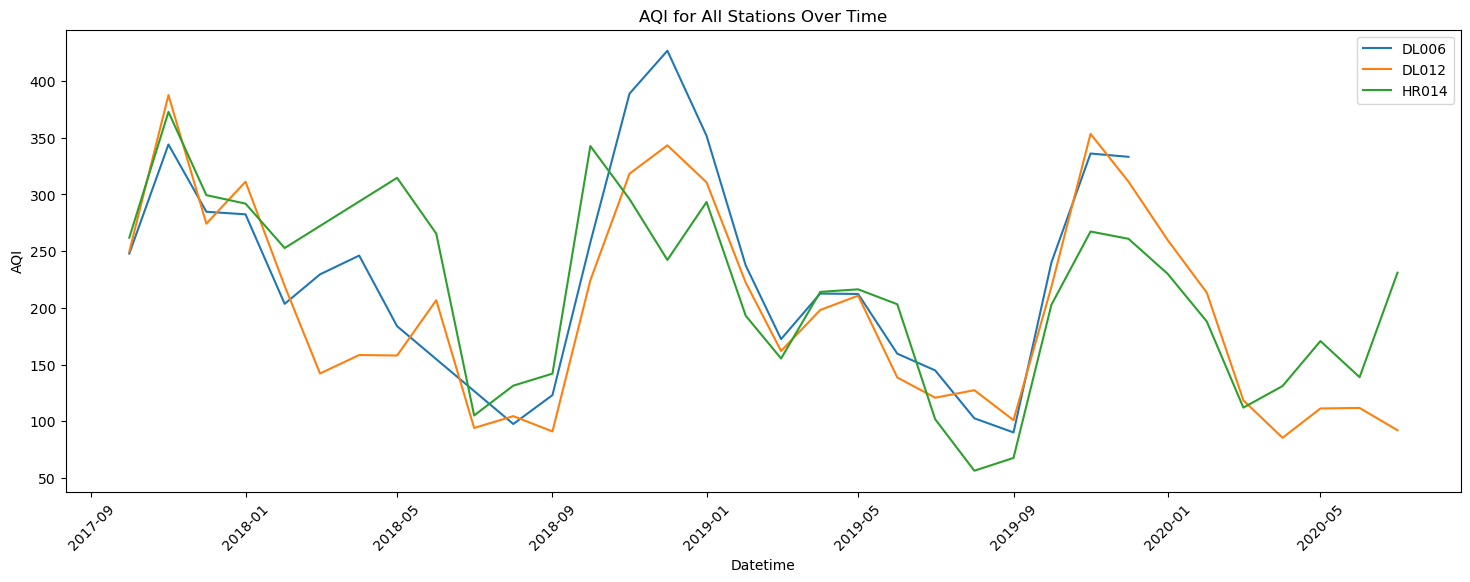

In [18]:
# Group by 'StationId' and 'Year_Month', calculate mean AQI
chart_df_2 = chart_df.groupby(['StationId', 'Datetime'])['AQI'].mean().reset_index()

# Create a line chart for each StationId
plt.figure(figsize=(18, 6))

# Plot AQI for each station
for station_id in chart_df_2['StationId'].unique():
    station_data = chart_df_2[chart_df_2['StationId'] == station_id]
    plt.plot(station_data['Datetime'], station_data['AQI'], label=station_id)

# Customize the plot
plt.title('AQI for All Stations Over Time')
plt.xlabel('Datetime')
plt.ylabel('AQI')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [19]:
chart_df.columns

Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI',
       'AQI_Category', 'Lon', 'Lat', 'Year', 'Month', 'DayOfWeek', 'HourOfDay',
       'Volatility_Last1D', 'Volatility_Last7D', 'Volatility_Last30D',
       'MA_Last7D', 'MA_Last30D'],
      dtype='object')

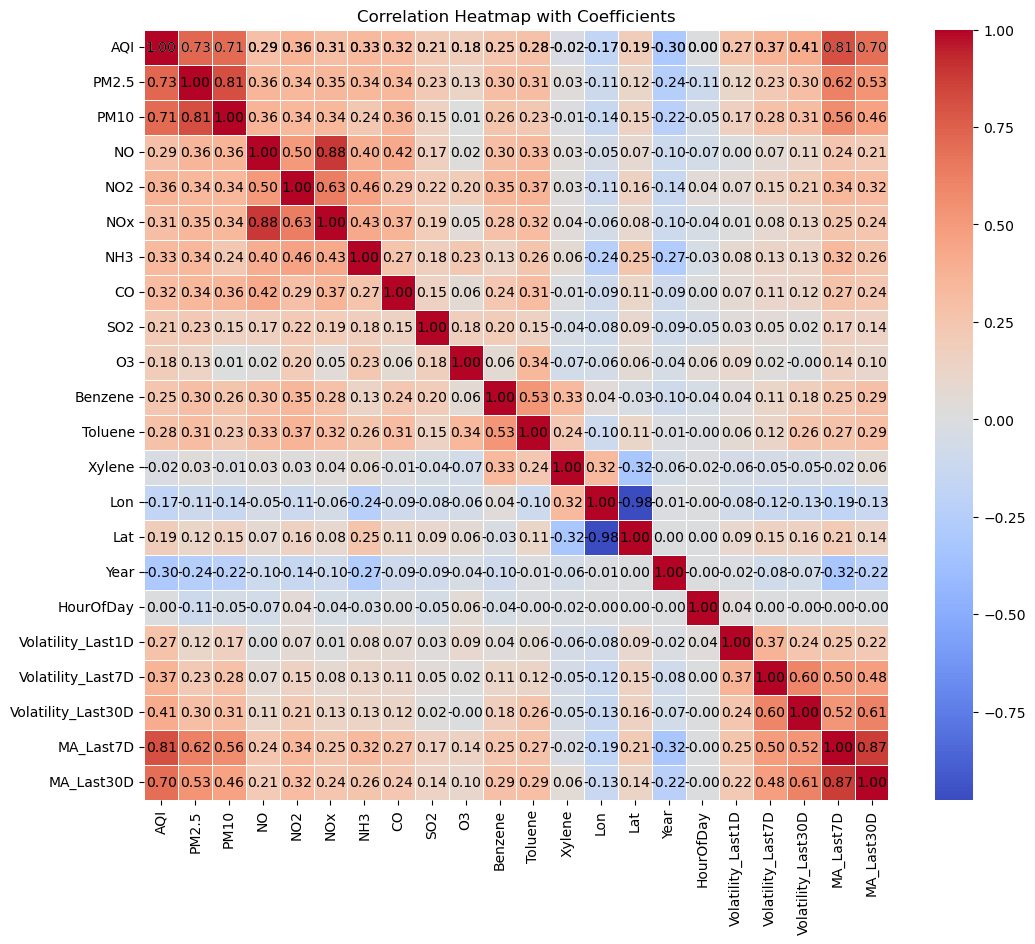

In [19]:
# Extract relevant columns for correlation heatmap
correlation_columns = ['AQI', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'Lon', 'Lat', 'Year', 'HourOfDay', 'Volatility_Last1D', 'Volatility_Last7D', 'Volatility_Last30D', 'MA_Last7D', 'MA_Last30D']

# Calculate the correlation matrix
correlation_matrix = chart_df[correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)

# Manually annotate the values
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j + 0.5, i + 0.5, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center')

# Set title
plt.title('Correlation Heatmap with Coefficients')

# Show the plot
plt.show()

Distribution of pollutants:

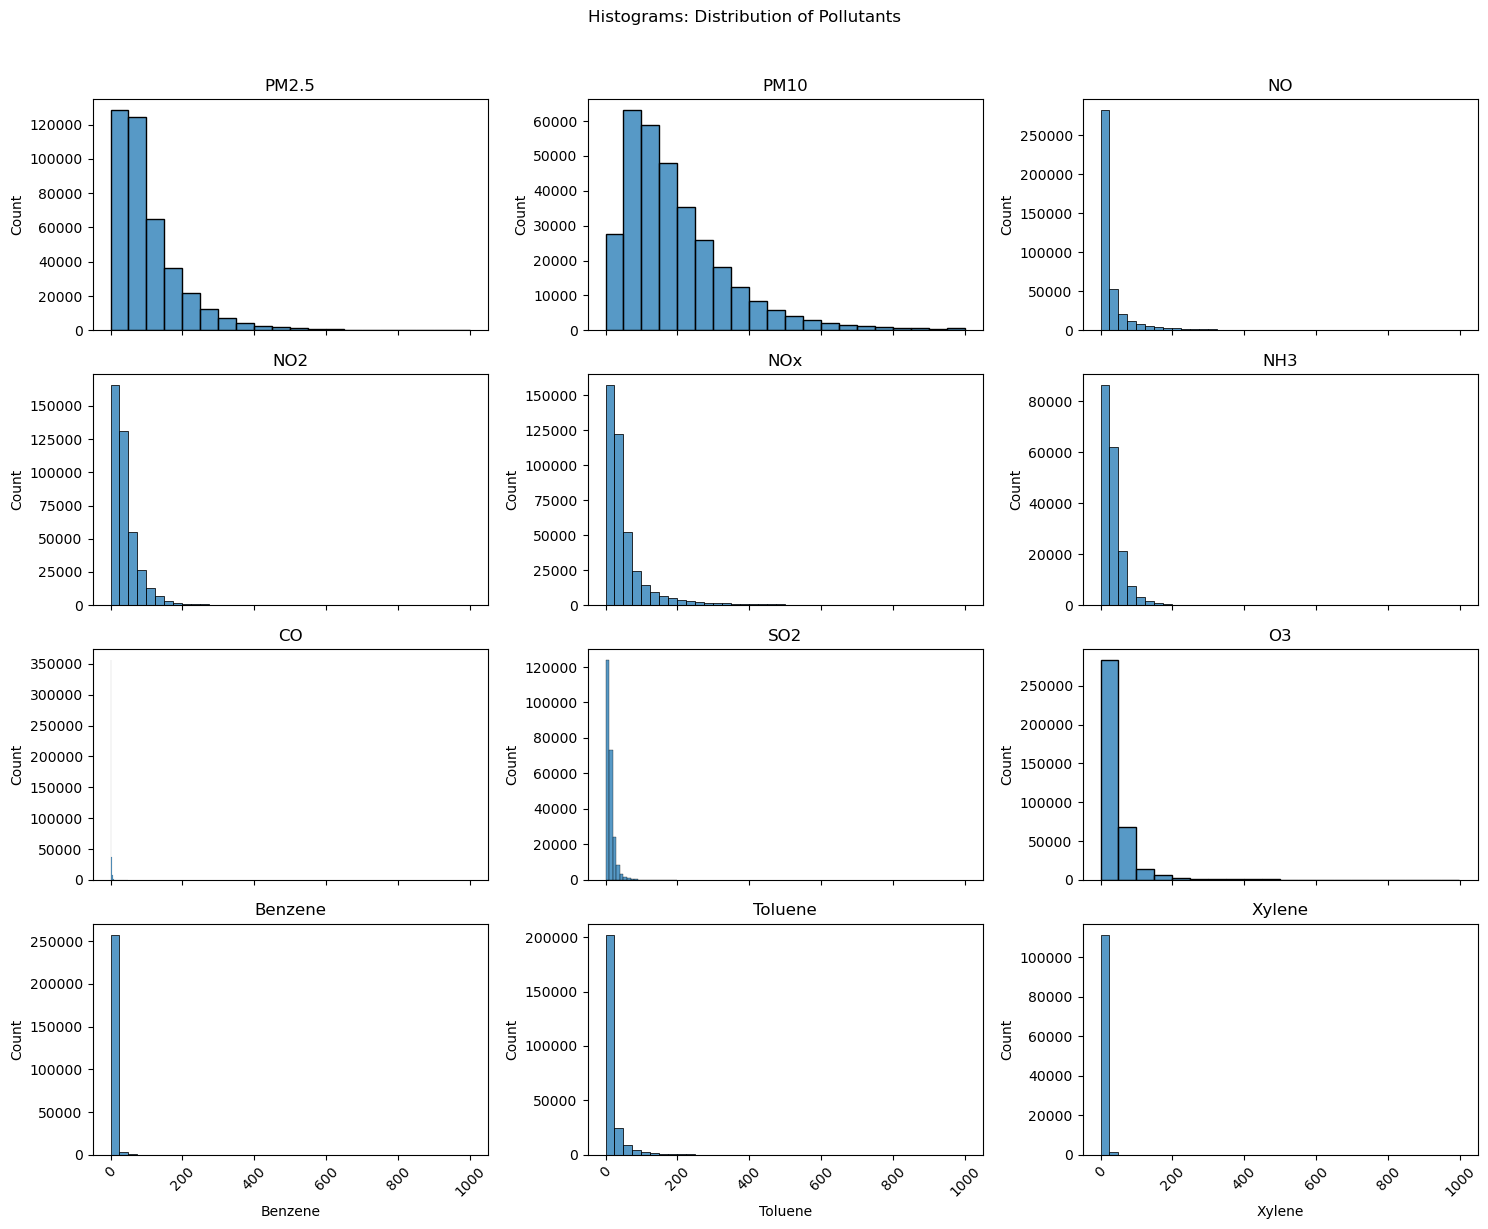

In [33]:
# Histograms: Distribution of pollutants
pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12), sharex=True)  # Use sharex to link x-axis across subplots
fig.suptitle('Histograms: Distribution of Pollutants', y=1.02)

for i, pollutant in enumerate(pollutants):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    sns.histplot(df[pollutant], bins=20, kde=False, ax=ax)
    ax.set_title(pollutant)
    
    # Rotate x-axis labels
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()  # Automatically adjusts subplot parameters to avoid overlapping
plt.show()

KeyboardInterrupt: 

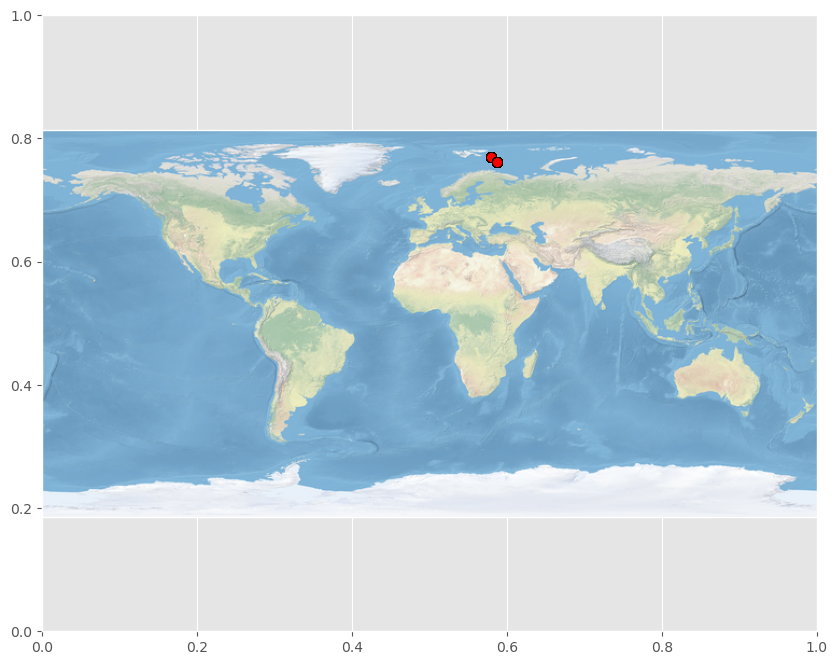

In [70]:
latitude, longitude = df['Lat'].tolist(), df['Lon'].tolist()

fig, ax = plt.subplots(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
sc = ax.scatter(longitude, latitude, c='red', s=50, edgecolors='k', transform=ccrs.PlateCarree())

def update(frame):
    sc.set_offsets(df[['Lon', 'Lat']])
    return sc,

ani = animation.FuncAnimation(fig, update, frames=range(len(df)), blit=True)

# Adjust the path to save the animation file
ani.save('animation_cartopy.gif', writer='pillow', fps=1)
plt.show()


Frequency of AQI categories across different months:

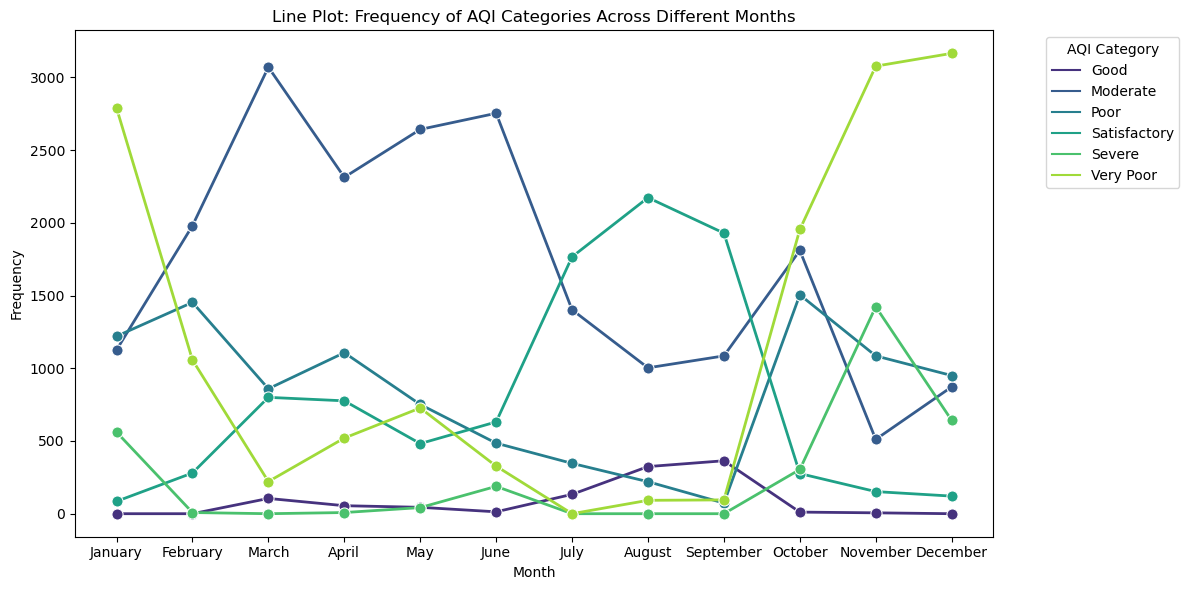

In [21]:
# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'Month' to categorical with specified order
chart_df['Month'] = pd.Categorical(chart_df['Month'], categories=month_order, ordered=True)

# Create a DataFrame with counts
df_counts = chart_df.groupby(['Month', 'AQI_Category']).size().reset_index(name='Count')

# Line Plot: Frequency of AQI categories across different months
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Count', hue='AQI_Category', data=df_counts, palette='viridis', marker='o', markersize=8, linewidth=2)
plt.title('Line Plot: Frequency of AQI Categories Across Different Months')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.legend(title='AQI Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.tight_layout()
plt.show()

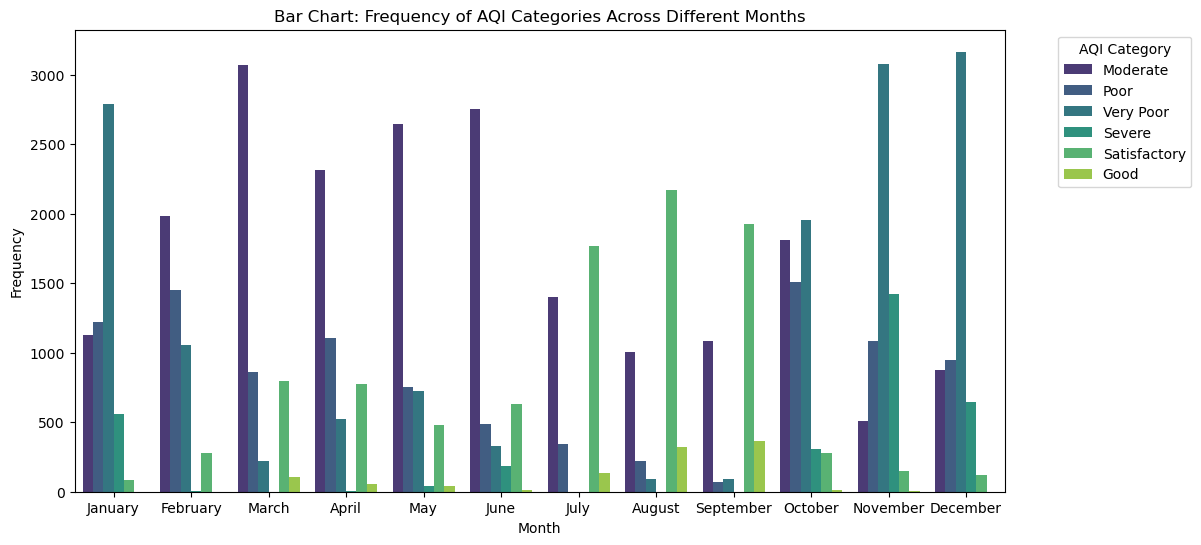

In [24]:
# Bar Chart: Frequency of AQI categories across different months
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', hue='AQI_Category', data=chart_df, palette='viridis')
plt.title('Bar Chart: Frequency of AQI Categories Across Different Months')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.legend(title='AQI Category', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.show()

Seasonal Decomposition for each station:

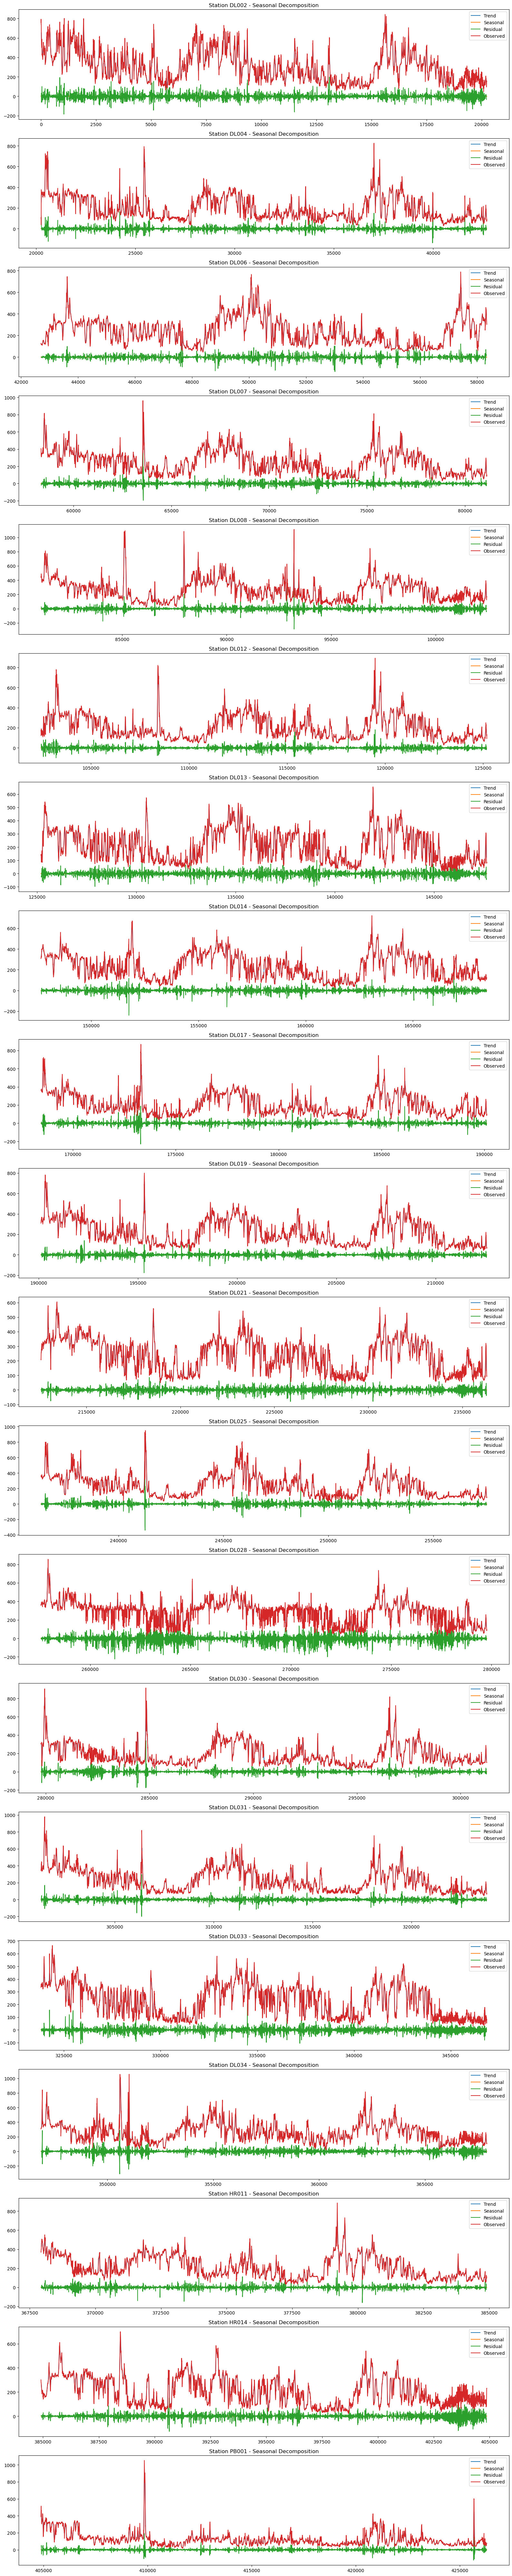

In [27]:
# Increase the chunksize
plt.rcParams['agg.path.chunksize'] = 20000

# Group by 'StationId' and perform Seasonal Decomposition for each group
grouped = df.groupby('StationId')['AQI']

# Adjust the figure size for better visibility
plt.figure(figsize=(16, 4 * len(grouped)))

for i, (station_id, group) in enumerate(grouped):
    plt.subplot(len(grouped), 1, i + 1)
    
    result = seasonal_decompose(group, model='additive', period=30)  # Adjust the period as needed
    
    plt.plot(result.trend, label='Trend')
    plt.plot(result.seasonal, label='Seasonal')
    plt.plot(result.resid, label='Residual')
    plt.plot(result.observed, label='Observed')
    
    plt.title(f'Station {station_id} - Seasonal Decomposition')
    plt.legend()

plt.tight_layout()
plt.show()

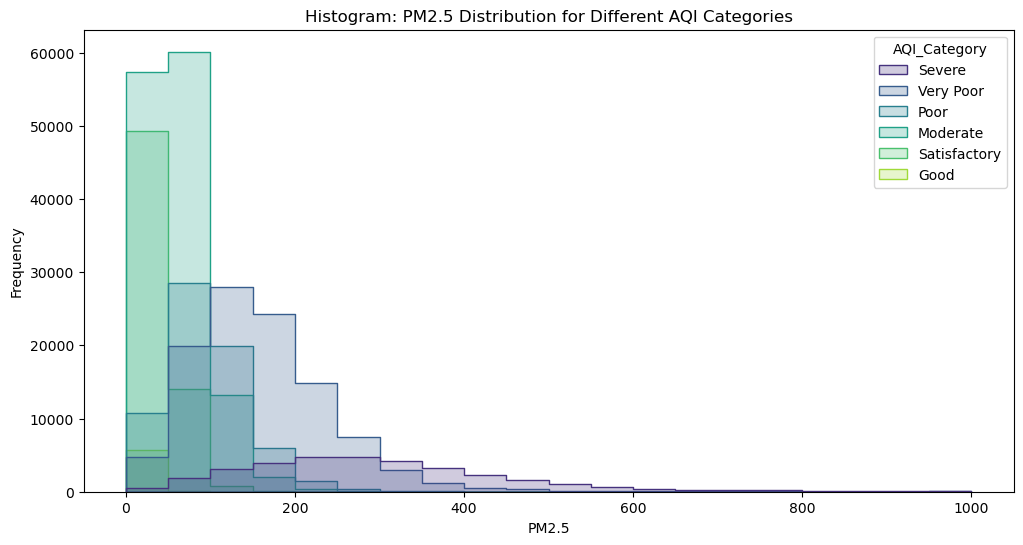

In [20]:
# Separate histograms for different AQI categories
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='PM2.5', hue='AQI_Category', element='step', common_norm=False, bins=20, palette='viridis')
plt.title('Histogram: PM2.5 Distribution for Different AQI Categories')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.show()